In [1]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import preprocessing
import pickle
import pandas as pd
from datasets import Dataset,DatasetDict

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def insert_random_mask(batch,data_collator):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [4]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
model_kb = preprocessing.create_model_MLM(model_checkpoint)
model_kb =model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [ ]:
#datasest
data_files = {"train": "swerick_data_random_train.pkl", "test": "swerick_data_random_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)


In [ ]:
from transformers import RobertaTokenizerFast
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("BPE_swerick_tokenizer", max_len=512)

In [ ]:
lm_datasets_train= preprocessing.chunk_and_pad(swerick_dataset["train"],roberta_tokenizer,128)

In [ ]:
lm_datasets_test= preprocessing.chunk_and_pad(swerick_dataset["test"],roberta_tokenizer,128)

In [ ]:
lm_datasets_roberta = DatasetDict({"train":lm_datasets_train,"test":lm_datasets_test})

In [ ]:
tokenized_datasets_train =preprocessing.tokenize_dataset(swerick_dataset["train"],roberta_tokenizer)
tokenized_datasets_test =preprocessing.tokenize_dataset(swerick_dataset["test"],roberta_tokenizer)
tokenized_datasets_train


In [ ]:
chunk_size = 128

In [ ]:
tokenized_datasets_train=tokenized_datasets_train.remove_columns("protocole")
tokenized_datasets_train=tokenized_datasets_train.remove_columns("protocole")

In [ ]:
lm_datasets_train = preprocessing.grouping_dataset(tokenized_datasets_train,chunk_size)
lm_datasets_test = preprocessing.grouping_dataset(tokenized_datasets_test,chunk_size)
lm_datasets

In [ ]:
lm_datasets = DatasetDict({'train':lm_datasets_train,'test':lm_datasets_test})
lm_datasets

In [ ]:
with open("lm_dataset_roberta.pkl","wb") as f:
    pickle.dump(lm_datasets,f)

In [17]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)
    
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 3663965
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 800106
    })
})

In [18]:
data_valid={"valid":"swerick_data_random_valid.pkl"}
valid_dataset_initial = load_dataset("pandas",data_files=data_valid) 

valid_dataset_initial

DatasetDict({
    valid: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 2570
    })
})

In [5]:
exbert_tokenizer = AutoTokenizer.from_pretrained("exbert_tokenizer")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
valid_dataset_roberta =preprocessing.chunk_and_pad(valid_dataset_initial["valid"],roberta_tokenizer,128)

In [ ]:
valid_dataset_roberta= Dataset.from_dict(valid_dataset_roberta)

In [ ]:
with open("valid_dataset_roberta.pkl","wb") as f:
     pickle.dump(valid_dataset_roberta,f)

In [6]:
with open("valid_dataset_exbert.pkl","rb") as f:
    valid_dataset_exbert= pickle.load(f)

valid_dataset_exbert

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'word_ids'],
    num_rows: 801549
})

In [ ]:
print(tokenizer.decode(valid_dataset[-1]["input_ids"]))
print(exbert_tokenizer.decode(valid_dataset_exbert[-1]["input_ids"]))

In [7]:

valid_dataset_exbert=valid_dataset_exbert.remove_columns(["word_ids"])

In [8]:
data_collator_exbert = preprocessing.data_collector_masking(exbert_tokenizer,0.15)
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)

NameError: name 'tokenizer' is not defined

trial with a manual implementation

In [ ]:
print(lm_datasets["train"])

lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])

print(lm_dataset_bis["test"])
eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset["valid"],data_collator_exbert)

print(eval_dataset)

In [9]:

valid_dataset_exbert=preprocessing.create_deterministic_eval_dataset(valid_dataset_exbert,data_collator_exbert)

Map:   0%|          | 0/801549 [00:00<?, ? examples/s]

In [10]:
valid_dataloader_exbert = preprocessing.create_dataloader(valid_dataset_exbert,64,default_data_collator)
valid_dataloader_exbert

In [ ]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to(device) for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,batch_size,default_data_collator)
print("ok")

#for batch in train_dataloader:
    #batch = to_device(batch)

#for batch in eval_dataloader:
    #batch = to_device(batch)




print(eval_dataloader.dataset)

In [20]:
from transformers import PreTrainedTokenizerFast

swerick_tokenizer= PreTrainedTokenizerFast(
    tokenizer_file="/home/laurinemeier/swerick/pretraining_from_scratch/tokenizer_swerick.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]"
)

In [21]:
import transformers
config = transformers.BertConfig.from_pretrained("pretraining_from_scratch/checkpoint-5258900")
mosaicBert = AutoModelForMaskedLM.from_pretrained("pretraining_from_scratch/checkpoint-5258900",config=config,trust_remote_code=True)
mosaicBert.to(device)

/home/laurinemeier/.cache/huggingface/modules/transformers_modules/checkpoint-5258900/bert_layers.py:177: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50328, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out

In [ ]:
from transformers import pipeline
pipe = pipeline(task="fill-mask", model=mosaicBert, tokenizer=swerick_tokenizer)
pipe("Hey [MASK]")

In [28]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-2175500")
model_hugging_face=model_hugging_face.to(device)

In [ ]:
model_hugging_face2 = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-400750")
model_hugging_face2=model_hugging_face2.to(device)

In [ ]:
model_exbert_new = AutoModelForMaskedLM.from_pretrained(model_checkpoint) 
model_exbert_new.resize_token_embeddings(len(exbert_tokenizer)) 
model_exbert_new = model_exbert_new.to("cpu")
print(model_exbert_new)

In [12]:
model_exbert = AutoModelForMaskedLM.from_pretrained("exbert-finetuned-imdb/checkpoint-5206440")
model_exbert =model_exbert.to(device)
print(model_exbert)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(51955, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
valid_data = preprocessing.chunk_and_pad(valid_dataset_initial["valid"],swerick_tokenizer,128)


In [ ]:
valid_data = Dataset.from_dict(valid_data)
valid_data

In [ ]:
with open("valid_scratch.pkl","wb") as f :
    pickle.dump(valid_data,f)

In [ ]:
with open("valid_scratch.pkl","rb") as f :
    valid_data = pickle.load(f)
    
valid_data

In [ ]:
data_collector =preprocessing.data_collector_masking(swerick_tokenizer,0.15)
valid_data = valid_data.remove_columns(["word_ids","token_type_ids"])
valid_scratch_loader =preprocessing.create_deterministic_eval_dataset(valid_data["valid"],data_collator)
valid_scratch_loader =preprocessing.create_dataloader(valid_scratch_loader,64,default_data_collator)

In [13]:
from evaluation import evaluation_task

#evaluation_task(model_kb,valid_scratch_loader,"finetuning_hugging_whitespace-finetuned-imdb/checkpoint-4179250")
#evaluation_task(model_hugging_face,valid_dataloader,"finetuning_hugging_whitespace-finetuned-imdb/checkpoint-4179250")
evaluation_task(model_exbert,valid_dataloader_exbert," ")

Trainer evaluation....
Manual perplexity...
 Perplexity: 2.431525432189666
Accuracy...
Accuracy: 0.7913578622944697


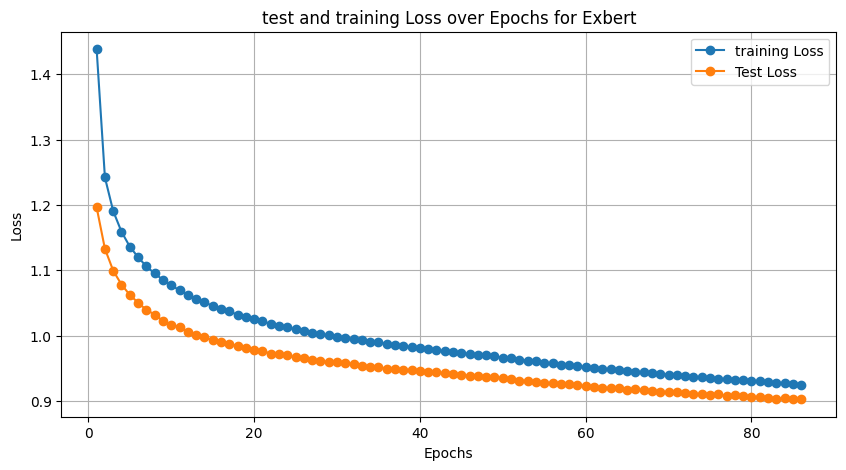

In [14]:
import json
import matplotlib.pyplot as plt

# Charger les données à partir du fichier JSON
#with open("finetuning/finetuning_hugging_whitespace-finetuned-imdb/checkpoint-5667750/trainer_state.json",'r') as file :
    #data_prev=json.load(file)

with open("exbert-finetuned-imdb/checkpoint-5206440/trainer_state.json", 'r') as file:
    data = json.load(file)


eval_loss = []
epoch_test=[]
train_loss=[]
train_epoch=[]
# for entry in data_prev['log_history']:
#     if 'loss' in entry:
#         train_loss.append(entry['loss'])
#         train_epoch.append((entry['epoch']))
#     if 'eval_loss' in entry:
#         eval_loss.append(entry['eval_loss'])
#         epoch_test.append((entry['epoch']))
        
for entry in data['log_history']:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        train_epoch.append((entry['epoch']))
        
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        epoch_test.append((entry['epoch']))
        
plt.figure(figsize=(10, 5))
plt.plot(train_epoch, train_loss, label='training Loss', marker='o')
plt.plot(epoch_test, eval_loss, label='Test Loss', marker='o')
plt.title('test and training Loss over Epochs for Exbert')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Losses on test set for from scratch and finetuned set
# 
import json
import matplotlib.pyplot as plt

# Charger les données à partir du fichier JSON
with open("finetuning/finetuning_hugging_whitespace-finetuned-imdb/checkpoint-5667750/trainer_state.json",'r') as file :
    data_prev=json.load(file)

with open("finetuning_hugging_whitespace_lr-finetuned-imdb/checkpoint-1030500/trainer_state.json", 'r') as file:
    data = json.load(file)

with open("pretraining_from_scratch/checkpoint-2419094/trainer_state.json","r") as file :
    scratch = json.load(file)
eval_loss = []
epoch_test=[]
scratch_loss=[]
scratch_epoch=[]
for entry in data_prev['log_history']:
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        epoch_test.append((entry['epoch']))
        
for entry in data['log_history']:
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        epoch_test.append((entry['epoch']))
        
for entry in scratch['log_history']:
    if 'eval_loss' in entry:
        scratch_loss.append(entry['eval_loss'])
        scratch_epoch.append((entry['epoch']))    

plt.figure(figsize=(10, 5))
plt.plot(scratch_epoch, scratch_loss, label='From Scratch Loss', marker='o')
plt.plot(epoch_test, eval_loss, label='Finetunig Loss', marker='o')
plt.title('From Scratch and finetuning test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Comparing perplexity nad accuracy on validation set for from scartch and fientuned model
# 
perplexity_scratch=[20.7,4.67,3.59,3.51,3.46,3.40,3.37,3.32]
accuracy_scratch =[60,67,71.2,71.6,71.9,72.1,72.3,72.6]
scratch_epoch =[1,8,27,31,34,38,41,46]

perplexity_finetuning=[9.86,3.03,2.96,2.90,2.76,2.745,2.70,2.59]
accuracy_finetuning=[59,74.6,75.1,75.4,76,76.5,77.4,77.5]
finetuning_epoch=[0,6,10,14,33,37,51,55]

plt.figure(figsize=(10, 5))
plt.plot(scratch_epoch, perplexity_scratch, label='From Scratch perplexity', marker='o')
plt.plot(finetuning_epoch, perplexity_finetuning, label='Finetunig perplexity', marker='o')
plt.title('From Scratch and finetuning perplexity on valid dataset over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(scratch_epoch, accuracy_scratch, label='From Scratch accuracy', marker='o')
plt.plot(finetuning_epoch, accuracy_finetuning, label='Finetunig accuracy', marker='o')
plt.title('From Scratch and finetuning accuracy on valid dataset over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Obeserving training and test loss through epochs
# 
with open("finetuning/finetuning_hugging_whitespace-finetuned-imdb/checkpoint-5667750/trainer_state.json",'r') as file :
    data_prev=json.load(file)

with open("finetuning_hugging_whitespace_lr-finetuned-imdb/checkpoint-1030500/trainer_state.json", 'r') as file:
    data = json.load(file)

train_loss = []
eval_loss = []
epoch_train = []
epoch_test=[]

for entry in data_prev['log_history']:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        epoch_train.append((entry['epoch']))
    elif 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        epoch_test.append((entry['epoch']))
        
for entry in data['log_history']:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        epoch_train.append((entry['epoch']))
    elif 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        epoch_test.append((entry['epoch']))

plt.figure(figsize=(10, 5))
plt.plot(epoch_train, train_loss, label='Training Loss', marker='o')
plt.plot(epoch_test, eval_loss, label='Evaluation Loss', marker='o')
plt.title('Training and Evaluation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabes')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# studying the learning rate and grad norm of training

import json
import matplotlib.pyplot as plt

# Charger les données à partir du fichier JSON
with open("finetuning/finetuning_hugging_whitespace-finetuned-imdb/checkpoint-5667750/trainer_state.json",'r') as file :
    data_prev=json.load(file)

with open("finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-2061000/trainer_state.json", 'r') as file:
    data = json.load(file)

learning_rate = []
grad_norm= []
epoch =[]

for entry in data_prev['log_history']:
    if 'loss' in entry:
        learning_rate.append(entry['learning_rate'])
        grad_norm.append((entry['grad_norm']))
        epoch.append((entry['epoch']))
   
        
for entry in data['log_history']:
    if 'loss' in entry:
        learning_rate.append(entry['learning_rate'])
        grad_norm.append((entry['grad_norm']))
        epoch.append((entry['epoch']))

plt.figure(figsize=(10, 5))
plt.plot(epoch, learning_rate, label='learning rate', marker='o')
plt.title('Training learning rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('learning rate')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epoch, grad_norm, label='Evaluation Loss', marker='o')
plt.title('Training  grad norm over Epochs')
plt.xlabel('Epochs')
plt.ylabel('grad norm')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
kb_loss=[3.05,2.13,1.69,1.41]
ft_loss=[3.02,1.59,1.04,0.91]
kb_r2=[0.802,0.858,0.89,0.78]
ft_r2=[0.808,0.896,0.93,0.95]
size=[100,200,500,1000]

plt.figure(figsize=(10,6))
plt.plot(size,kb_loss,label='KB-Loss',marker='o')
plt.plot(size,ft_loss,label='ft-Loss',marker='o')
plt.xlabel=('Size of training dataset')
plt.ylabel=('Loss')
plt.title('Loss of the finetuned model and KB bert fo the year regression over different size of  training dataset')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(size,kb_r2,label='KB-r2',marker='o')
plt.plot(size,ft_r2,label='ft-r2',marker='o')
plt.xlabel=('Size of training dataset')
plt.ylabel=('R2')
plt.title('R2 of the finetuned model and KB bert fo the year regression over different size of  training dataset')
plt.legend()
plt.show()

In [ ]:
pad_token_id= tokenizer.pad_token_id
sep_token_id = tokenizer.sep_token_id

In [ ]:
def evaluate_model_token(model,dataloader):
    model.eval()
    correct_pred=[]
    incorrect_pred=[]

    for batch in dataloader:
        batch = {key: value.to(device) for key, value in batch.items()} 
        with torch.no_grad():
            outputs=model(**batch)
        predictions=torch.argmax(outputs.logits,dim=-1)
        indices_tokens_masked = torch.nonzero(batch["labels"] != -100, as_tuple=False)
        correct_indices=[]
        incorrect_indices=[]
        for id,label in enumerate(batch["labels"][indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]]):
            if label.item() == predictions[indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]][id]:
                correct_indices.append(id)
            else :
                incorrect_indices.append(id)
        correct_pred.extend(batch['labels'][indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]][correct_indices])
        incorrect_pred.extend(batch['labels'][indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]][incorrect_indices])

    return correct_pred,incorrect_pred

In [ ]:
hugging_face_correct,hugging_face_incorrect = evaluate_model_token(model_hugging_face,valid_dataloader)

In [ ]:
hugging_face_incorrect_unique = list(set(hugging_face_incorrect))
hugging_face_incorrect_unique


In [ ]:
hugging_correct,hugging_incorrect=evaluate_model_token(model_hugging_face,valid_dataloader)

In [ ]:
base_correct,base_incorrect=evaluate_model_token(model_kb,valid_dataloader)

In [ ]:
from collections import Counter
def decoding_text(list):
    counter = Counter(list)

    # Trier les éléments par leur fréquence décroissante
    sorted_numbers = sorted(counter.items(), key=lambda x: x[1], reverse=True)

    # Extraire les chiffres triés
    unique_sorted_numbers = [num for num, _ in sorted_numbers]

    decoded_texts = []
    for tensor in unique_sorted_numbers:
        decoded_text = tokenizer.decode(tensor.item())
        decoded_texts.append(decoded_text)
    return decoded_texts

In [ ]:
decoded_base_correct = decoding_text(base_correct)
decoded_hugging_correct = decoding_text(hugging_correct)

In [ ]:
print(len(decoded_base_correct)/(len(decoded_base_correct)+len(base_incorrect)))
print(len(decoded_hugging_correct)/(len(decoded_hugging_correct)+len(hugging_incorrect)))

In [ ]:
good_tokens = list(set(decoded_hugging_correct)-set(decoded_base_correct))
print(len(good_tokens))
good_tokens

In [ ]:
max_length=128

In [ ]:
print(tokenizer.decode(valid_dataset[-1]["input_ids"]))
print(swerick_tokenizer.decode(valid_data[-1]["input_ids"]))
print(len(valid_dataset[0]["input_ids"]))
print(len(valid_data[0]["input_ids"]))

In [23]:
subset = valid_dataset_initial["valid"].select(range(100))
subset_kb = Dataset.from_dict(preprocessing.chunk_and_pad(subset,tokenizer,128))
subset_scratch =Dataset.from_dict(preprocessing.chunk_and_pad(subset,swerick_tokenizer,128))
subset_exbert = Dataset.from_dict(preprocessing.chunk_and_pad(subset,exbert_tokenizer,128))

In [13]:
subset_exbert

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'word_ids'],
    num_rows: 15430
})

In [25]:
from evaluation import l2R_MLM_Crossentropy

In [29]:
pll,pll_bis = l2R_MLM_Crossentropy(model_hugging_face,subset_kb,tokenizer)

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Map:   0%|          | 0/16128 [00:00<?, ? examples/s]

Pseudo log perplexity hugging face: 176.61581420898438
Average pseudo log perplexity hugging_face: 1.3798110485076904


In [ ]:
pll

In [ ]:
# Undertanding the loss
import torch.nn as nn

vocab_size = 50328
loss_function=nn.CrossEntropyLoss(reduction='none')
losses=[]
token_indices_with_high_loss = []

for batch in valid_dataloader :
    batch={key : batch[key].to(device) for key in batch.keys()}
    output= model_kb(**batch)
    loss = loss_function(output.logits.view(-1,output.logits.size(-1)), batch['labels'].view(-1))
    del output
    losses.extend(loss.tolist())
    token_indices_with_high_loss.extend(batch['labels'].view(-1).tolist())
    
    
high_loss_indices = sorted(range(len(losses)), key=lambda i: losses[i], reverse=True)[:50]
high_loss_values = [losses[i] for i in high_loss_indices]
print(high_loss_values)
high_loss_tokens = [token_indices_with_high_loss[i] for i in high_loss_indices]
print(high_loss_tokens)
high_loss_words = [tokenizer.decode([idx]) for idx in high_loss_tokens]
print(high_loss_words)

In [ ]:
from datasets import Dataset
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
valid_dataset=valid_dataset.remove_columns(["word_ids","token_type_ids"])
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset["valid"],data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,64,default_data_collator)

In [ ]:
import torch.nn as nn

vocab_size = 50328
loss_function=nn.CrossEntropyLoss(reduction='none')
losses=[]
losses_f=[]
losses_diff=[]
token_indices_with_high_loss = []
token_id =  tokenizer.convert_tokens_to_ids('Riksdagen')
for batch in valid_dataloader :
    batch={key : batch[key].to(device) for key in batch.keys()}
    with torch.no_grad():
     output1= model_kb(**batch)
     output2=model_hugging_face(**batch)
    mask = (batch['labels'].view(-1) == token_id)
    loss1 = loss_function(output1.logits.view(-1,output1.logits.size(-1)), batch['labels'].view(-1))
    loss2= loss_function(output2.logits.view(-1,output2.logits.size(-1)), batch['labels'].view(-1))
    del output1
    del output2
    loss_diff =(loss1-loss2)
    losses.extend(loss1.tolist())
    losses_f.extend(loss2.tolist())
    losses_diff.extend(loss_diff.tolist())
    token_indices_with_high_loss.extend(batch['labels'].view(-1).tolist())
    
    
high_loss_diff_indices = sorted(range(len(losses_diff)), key=lambda i: losses_diff[i], reverse=True)[:50]
high_loss_indices = sorted(range(len(losses)), key=lambda i: losses[i], reverse=True)[:50]
high_loss2_indices = sorted(range(len(losses_f)), key=lambda i: losses_f[i], reverse=True)[:50]
high_loss_values = [losses[i] for i in high_loss_indices]
high_loss2_values = [losses[i] for i in high_loss2_indices]
high_loss_diff_values = [losses_diff[i] for i in high_loss_diff_indices]
print(high_loss_values)
high_loss_tokens = [token_indices_with_high_loss[i] for i in high_loss_indices]
high_loss2_tokens = [token_indices_with_high_loss[i] for i in high_loss2_indices]
high_loss_diff_tokens = [token_indices_with_high_loss[i] for i in high_loss_diff_indices]
high_loss_words = [tokenizer.decode([idx]) for idx in high_loss_tokens]
print(high_loss_words)
high_loss2_words = [tokenizer.decode([idx]) for idx in high_loss2_tokens]
print(high_loss2_words)
high_loss_diff_words = [tokenizer.decode([idx]) for idx in high_loss_diff_tokens]
print(high_loss_diff_words)

In [ ]:
high_loss_indices = sorted(range(len(losses)), key=lambda i: losses[i], reverse=True)
index = high_loss_indices.index(token_id)

print(losses[index])

In [ ]:
print(len(losses))
print(len(high_loss_indices))

In [ ]:
high_loss_diff_indices = sorted(range(len(losses_diff)), key=lambda i: losses_diff[i], reverse=True)[:300]
high_loss_indices = sorted(range(len(losses)), key=lambda i: losses[i], reverse=True)[:300]
high_loss2_indices = sorted(range(len(losses_f)), key=lambda i: losses_f[i], reverse=True)[:300]
high_loss_values = [losses[i] for i in high_loss_indices]
high_loss2_values = [losses[i] for i in high_loss2_indices]
high_loss_diff_values = [losses_diff[i] for i in high_loss_diff_indices]
print(high_loss_values)
high_loss_tokens = [token_indices_with_high_loss[i] for i in high_loss_indices]
high_loss2_tokens = [token_indices_with_high_loss[i] for i in high_loss2_indices]
high_loss_diff_tokens = [token_indices_with_high_loss[i] for i in high_loss_diff_indices]
high_loss_words = [tokenizer.decode([idx]) for idx in high_loss_tokens]
print(high_loss_words)
high_loss2_words = [tokenizer.decode([idx]) for idx in high_loss2_tokens]
print(high_loss2_words)
high_loss_diff_words = [tokenizer.decode([idx]) for idx in high_loss_diff_tokens]
print(high_loss_diff_words)

In [ ]:
index = high_loss_diff_words.index('Riksdagen')
print(index)
high_loss_diff_values[index]

In [ ]:
high_words_bis = ['OS', 'liknas', '##olding', 'möd', 'Meri', 'talan', '##GE', '##rard', '##dju', 'Ts', '##ää', 'bor', '##edi', 'inva', '##ssor', 'Brev', 'MT', 'försk', 'Sweden', '##my', 'forsk', 'AN', 'dun', 'Möt', '##perio', '##atal', '##inar', 'RR', '##uch', '##göra', '147', 'fristående', 'anda', 'Meg', 'yn', '##core', 'RÄTT', 'fri', 'häng', 'Kons', '##äl', 'lycka', 'Len', 'til', 'bar', 'hos', '##vatt', 'Mind', 'Sn', 'Kommen']
high_loss_words_set = set(high_loss_words)
high_words_bis_set = set(high_words_bis)

# Use the intersection method
inter = high_loss_words_set.intersection(high_words_bis_set)
print(inter)